## S&P500 Model

In [1]:
#spark sql imports
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import Row
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.functions import col, when
from pyspark.sql.functions import split, explode
from pyspark.sql.functions import regexp_replace
from pyspark.sql.types import *
from pyspark.sql.functions import avg, to_date, from_utc_timestamp



import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np


In [2]:
#spark ML imports
from pyspark.ml import Pipeline
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer, StringIndexer, CountVectorizer, IDF
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler


In [3]:
spark = SparkSession.builder.appName("S&P").getOrCreate()

:: loading settings :: url = jar:file:/usr/lib/spark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-d4d922d9-7a59-4df9-991b-7228146c7db1;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;4.4.0 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.828 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlombok#lombok;1.16.8 in central
	found com.google.cloud#google-cloud-storage;2.16.0 in central
	found com.google.guava#guava;31.1-jre in centra

In [4]:
input_bucket = "gs://bigdatafinaldatakira/S&P500_Prices.csv" 

df = pd.read_csv(input_bucket)

In [5]:
df.dtypes

Date            object
Open           float64
High           float64
Low            float64
Close*         float64
Adj Close**    float64
Volume           int64
dtype: object

In [6]:
df.head()

,Date,Open,High,Low,Close*,Adj Close**,Volume
0,12/30/2019,3240.09,3240.92,3216.57,3221.29,3221.29,3021720000
1,12/31/2019,3215.18,3231.72,3212.03,3230.78,3230.78,2894760000
2,1/2/2020,3244.67,3258.14,3235.53,3257.85,3257.85,3459930000
3,1/3/2020,3226.36,3246.15,3222.34,3234.85,3234.85,3484700000
4,1/6/2020,3217.55,3246.84,3214.64,3246.28,3246.28,3702460000


In [7]:
df['percent_change'] = (df['Adj Close**'] - df['Open']) / df['Open'] * 100

In [8]:
df.describe()

,Open,High,Low,Close*,Adj Close**,Volume,percent_change
count,256.000000,256.000000,256.000000,256.000000,256.000000,2.560000e+02,256.000000
mean,3219.963672,3244.199883,3192.515156,3219.805664,3219.805664,4.907465e+09,0.002652
std,318.327467,308.581505,329.615003,318.774862,318.774862,1.360653e+09,1.396194
min,2290.710000,2300.730000,2191.860000,2237.400000,2237.400000,1.883780e+09,-5.709920
25%,3046.387500,3080.742500,2999.270000,3040.015000,3040.015000,3.927645e+09,-0.609296
50%,3278.890000,3287.020000,3253.160000,3275.360000,3275.360000,4.629705e+09,0.132554
75%,3411.562500,3431.692500,3385.597500,3411.310000,3411.310000,5.456428e+09,0.635842
max,3764.610000,3769.990000,3730.210000,3756.070000,3756.070000,9.053950e+09,5.487570


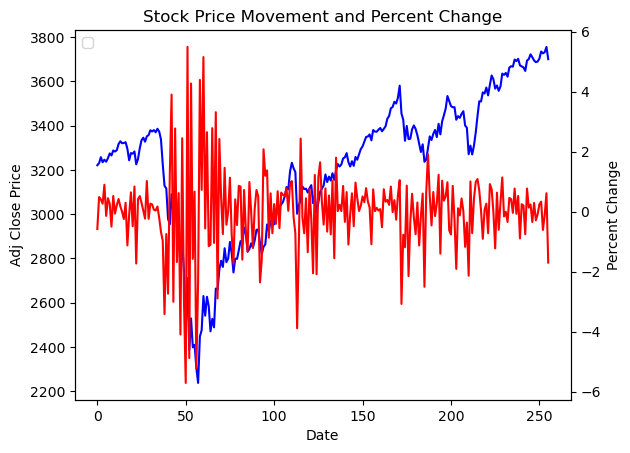

In [9]:
##Stock price graphic

df_graphic = df

#df_graphic['Date'] = pd.to_datetime(df_graphic['Date'])

# Set the 'date' column as the index
#df_graphic.set_index('Date', inplace=True)

# Create subplots
fig, ax1 = plt.subplots()

# Plot stock price
ax1.plot(df_graphic.index, df_graphic['Adj Close**'], color='blue')
ax1.set_ylabel('Adj Close Price')

# Create a secondary y-axis for percentage change
ax2 = ax1.twinx()
ax2.plot(df_graphic.index, df_graphic['percent_change'], color='red')
ax2.set_ylabel('Percent Change')

# Set labels and title
ax1.set_xlabel('Date')
ax1.set_title('Stock Price Movement and Percent Change')

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax1.legend(lines, labels, loc='upper left')

# Display the graph
plt.show()

In [10]:
# Define the function to apply the conditions and return the corresponding values
def assign_value(x):
    if x < 0:
        return 0
    else:
        return 1

# Apply the function to create the new column based on the conditions
df['percent_change_flag'] = df['percent_change'].apply(assign_value)

In [11]:
quantiles = [0.25, 0.35, .4, 0.45, 0.5, 0.55, 0.65, 0.75, 0.85, 0.95]
column_distribution = df.quantile(quantiles)
print(column_distribution)

           Open       High        Low     Close*  Adj Close**        Volume  \
0.25  3046.3875  3080.7425  2999.2700  3040.0150    3040.0150  3.927645e+09   
0.35  3157.4275  3184.8175  3136.2975  3158.9000    3158.9000  4.112892e+09   
0.40  3224.2100  3240.9200  3205.6500  3225.5200    3225.5200  4.314690e+09   
0.45  3241.4175  3266.4875  3226.0800  3246.5125    3246.5125  4.452350e+09   
0.50  3278.8900  3287.0200  3253.1600  3275.3600    3275.3600  4.629705e+09   
0.55  3306.1700  3327.6075  3282.2800  3310.1425    3310.1425  4.741125e+09   
0.65  3360.4950  3379.6050  3336.0475  3359.7900    3359.7900  5.000118e+09   
0.75  3411.5625  3431.6925  3385.5975  3411.3100    3411.3100  5.456428e+09   
0.85  3543.6350  3562.9425  3509.1475  3536.3125    3536.3125  6.375800e+09   
0.95  3686.5650  3700.1250  3664.7675  3692.6250    3692.6250  7.994038e+09   

      percent_change  percent_change_flag  
0.25       -0.609296                  0.0  
0.35       -0.210170                  0.0 

In [12]:
# Assuming you have a column named 'date' containing datetime values
start_date = '2020-03-15'
end_date = '2020-12-31'

# Convert the 'date' column to datetime type if it's not already
df['Date'] = pd.to_datetime(df['Date'])

# Filter the DataFrame based on the date range
filtered_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

In [13]:
filtered_df.head()

,Date,Open,High,Low,Close*,Adj Close**,Volume,percent_change,percent_change_flag
52,2020-03-16,2508.59,2562.98,2380.94,2386.13,2386.13,7805450000,-4.881627,0
53,2020-03-17,2425.66,2553.93,2367.04,2529.19,2529.19,8370250000,4.268117,1
54,2020-03-18,2436.50,2453.57,2280.52,2398.10,2398.10,8799300000,-1.576031,0
55,2020-03-19,2393.48,2466.97,2319.78,2409.39,2409.39,7956100000,0.664722,1
56,2020-03-20,2431.94,2453.01,2295.56,2304.92,2304.92,9053950000,-5.222991,0


## Append Sentiment Scores

In [14]:
df = spark.createDataFrame(filtered_df)

In [30]:
df_sentiment = spark.read.csv("gs://bigdatafinaldatakira/notebooks_jupyter_output_part-00000-1daa1e9e-e4ae-4b8d-8766-2d86b4b744d7-c000.csv", header = True)

df_sentiment.show()


+--------------------+--------------------+-------------------+
|          created_at|                text|predicted_sentiment|
+--------------------+--------------------+-------------------+
|2020-06-16T08:30:...|this is superb we...|                joy|
|2020-06-16T08:30:...|the economic impa...|               null|
|are there gaps in...|                fear|               null|
|2020-06-16T08:30:...|building secretar...|                joy|
|2020-06-16T08:30:...|please dont on th...|               fear|
|2020-06-16T08:30:...|the schools my da...|               fear|
|2020-06-16T08:30:...|lagos rivers oyo ...|               fear|
|2020-06-16T08:30:...|president ramapho...|                joy|
|2020-06-16T08:30:...|47000 ventilators...|                joy|
|2020-06-16T08:30:...|14  days ago 13 l...|                joy|
|2020-06-16T08:30:...|1 when you wake u...|                sad|
|2020-06-16T08:30:...|teagues airshield...|               null|
|httpstco5rsj7xlbl...|               ang

In [31]:
df_sentiment.head(2)[1](1)

Row(2020-06-16T08:30:07.000Z=1)

In [32]:
df_sentiment = df_sentiment.withColumn('date', to_date(from_utc_timestamp('created_at', 'UTC')))

df_sentiment.show()

+--------------------+--------------------+-------------------+----------+
|          created_at|                text|predicted_sentiment|      date|
+--------------------+--------------------+-------------------+----------+
|2020-06-16T08:30:...|this is superb we...|                joy|2020-06-16|
|2020-06-16T08:30:...|the economic impa...|               null|2020-06-16|
|are there gaps in...|                fear|               null|      null|
|2020-06-16T08:30:...|building secretar...|                joy|2020-06-16|
|2020-06-16T08:30:...|please dont on th...|               fear|2020-06-16|
|2020-06-16T08:30:...|the schools my da...|               fear|2020-06-16|
|2020-06-16T08:30:...|lagos rivers oyo ...|               fear|2020-06-16|
|2020-06-16T08:30:...|president ramapho...|                joy|2020-06-16|
|2020-06-16T08:30:...|47000 ventilators...|                joy|2020-06-16|
|2020-06-16T08:30:...|14  days ago 13 l...|                joy|2020-06-16|
|2020-06-16T08:30:...|1 w

In [45]:
df_sentiment = df_sentiment.na.drop(subset=["date"])
df_sentiment = df_sentiment.na.drop(subset=["predicted_sentiment"])


In [46]:
df_sentiment.count()

897248

In [47]:
df_sentiment.show()

+--------------------+--------------------+-------------------+----------+
|          created_at|                text|predicted_sentiment|      date|
+--------------------+--------------------+-------------------+----------+
|2020-06-16T08:30:...|this is superb we...|                  1|2020-06-16|
|2020-06-16T08:30:...|building secretar...|                  1|2020-06-16|
|2020-06-16T08:30:...|please dont on th...|                  0|2020-06-16|
|2020-06-16T08:30:...|the schools my da...|                  0|2020-06-16|
|2020-06-16T08:30:...|lagos rivers oyo ...|                  0|2020-06-16|
|2020-06-16T08:30:...|president ramapho...|                  1|2020-06-16|
|2020-06-16T08:30:...|47000 ventilators...|                  1|2020-06-16|
|2020-06-16T08:30:...|14  days ago 13 l...|                  1|2020-06-16|
|2020-06-16T08:30:...|1 when you wake u...|                  0|2020-06-16|
|2020-06-16T08:30:...|study launched to...|                  0|2020-06-16|
|2020-06-16T08:30:...|we 

In [48]:
sentiment_mapping = {
    "joy": 1,
    "sad": 0,
    "fear": 0,
    "anger": 0
}

df_sentiment = df_sentiment.withColumn("predicted_sentiment", when(df_sentiment["predicted_sentiment"] == "joy", 1).otherwise(df_sentiment["predicted_sentiment"]))
df_sentiment = df_sentiment.withColumn("predicted_sentiment", when(df_sentiment["predicted_sentiment"] == "anger", 0).otherwise(df_sentiment["predicted_sentiment"]))
df_sentiment = df_sentiment.withColumn("predicted_sentiment", when(df_sentiment["predicted_sentiment"] == "sad", 0).otherwise(df_sentiment["predicted_sentiment"]))
df_sentiment = df_sentiment.withColumn("predicted_sentiment", when(df_sentiment["predicted_sentiment"] == "fear", 0).otherwise(df_sentiment["predicted_sentiment"]))


In [49]:
# Group by 'date' and calculate the average of 'value'
condensed_df_sentiment = df_sentiment.groupBy('date').agg(avg('predicted_sentiment').alias('average_value'))

# Show the condensed DataFrame
condensed_df_sentiment.show()

+----------+-------------------+
|      date|      average_value|
+----------+-------------------+
|2020-04-30|0.34469548133595285|
|2020-05-23| 0.2860974240628703|
|2020-05-08| 0.3065602653124676|
|2020-05-24|0.26028573180452513|
|2020-05-10| 0.2837634300632594|
|2020-04-26|0.33095763902830755|
|2020-04-21|0.32084805653710247|
|2020-06-05|0.24929438792254677|
|2020-04-19|0.33421725542191494|
|2020-06-17|0.24420579694263328|
|2020-04-13|0.31445170660856936|
|2020-06-12|0.29110786245471304|
|2020-05-17|  0.313383571028212|
|2020-03-29| 0.2919143876337693|
|2020-04-14|0.31705770450221943|
|2020-03-21|0.21892497200447927|
|2020-06-15|0.22549838844455056|
|2020-05-25|0.27866036925719195|
|2020-04-23|0.33116623324664934|
|2020-05-19|0.31450938209633084|
+----------+-------------------+
only showing top 20 rows



In [50]:
#change date format in s&p data
df = df.withColumn('date', to_date(from_utc_timestamp('Date', 'UTC')))
df.show()

+----------+-------+-------+-------+-------+-----------+----------+-------------------+-------------------+
|      date|   Open|   High|    Low| Close*|Adj Close**|    Volume|     percent_change|percent_change_flag|
+----------+-------+-------+-------+-------+-----------+----------+-------------------+-------------------+
|2020-03-16|2508.59|2562.98|2380.94|2386.13|    2386.13|7805450000| -4.881626730553818|                  0|
|2020-03-17|2425.66|2553.93|2367.04|2529.19|    2529.19|8370250000|   4.26811671874872|                  1|
|2020-03-18| 2436.5|2453.57|2280.52| 2398.1|     2398.1|8799300000|-1.5760311922840178|                  0|
|2020-03-19|2393.48|2466.97|2319.78|2409.39|    2409.39|7956100000| 0.6647224961144381|                  1|
|2020-03-20|2431.94|2453.01|2295.56|2304.92|    2304.92|9053950000| -5.222990698783686|                  0|
|2020-03-23|2290.71|2300.73|2191.86| 2237.4|     2237.4|7411380000|-2.3272260565501504|                  0|
|2020-03-24|2344.44|2449.71|

In [53]:
# Perform the join operation by date
joined_df = condensed_df_sentiment.join(df.select('Date', 'percent_change'), on='date', how='inner')

# Show the joined DataFrame
joined_df.show()

+----------+-------------------+--------------------+
|      date|      average_value|      percent_change|
+----------+-------------------+--------------------+
|2020-04-30|0.34469548133595285| -0.6305208962404174|
|2020-05-08| 0.3065602653124676|  0.7209084064727143|
|2020-04-21|0.32084805653710247| -1.7326137151188052|
|2020-06-05|0.24929438792254677|  0.9510594720339741|
|2020-06-17|0.24420579694263328| -0.7219088494418384|
|2020-04-13|0.31445170660856936| -0.7486181292812808|
|2020-06-12|0.29110786245471304| -0.9680759612378874|
|2020-04-14|0.31705770450221943|  1.4601974974154233|
|2020-06-15|0.22549838844455056|   2.432726738282291|
|2020-06-04|0.24829135848703304|0.025389193844886925|
|2020-04-29|0.32968765395605476|  0.7212708072065467|
|2020-04-06|0.28556448794127925|  3.3122857098530663|
|2020-04-23|0.33116623324664934|-0.44904320350694527|
|2020-05-19|0.31450938209633084| -0.8699073116303077|
|2020-06-10|0.25959921524663676| -0.7244617883750085|
|2020-05-06|0.32322542901716

## Linear Regression 

In [63]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

vectorAssembler = VectorAssembler(inputCols=["average_value"], outputCol="features")
data = vectorAssembler.transform(joined_df).select("features", "percent_change")

(trainingData, testData) = data.randomSplit([0.7, 0.3])

lr = LinearRegression(featuresCol="features", labelCol="percent_change")

lrModel = lr.fit(trainingData)

predictions = lrModel.transform(testData)

predictions.show()

evaluator = RegressionEvaluator(labelCol="percent_change", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

evaluator = RegressionEvaluator(labelCol="percent_change", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)

print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared:", r2)

23/05/22 15:03:36 WARN org.apache.spark.ml.util.Instrumentation: [5c8b5d67] regParam is zero, which might cause numerical instability and overfitting.


+--------------------+--------------------+--------------------+
|            features|      percent_change|          prediction|
+--------------------+--------------------+--------------------+
|[0.24929438792254...|  0.9510594720339741| -0.3472957616234762|
|[0.3065602653124676]|  0.7209084064727143| 0.13538607926366142|
|[0.32968765395605...|  0.7212708072065467|  0.3303218950443121|
|[0.22549838844455...|   2.432726738282291| -0.5478671552228727|
|[0.31705770450221...|  1.4601974974154233| 0.22386675054037575|
|[0.3175343811394892]|  -0.721897675045021| 0.22788455603418845|
|[0.33116623324664...|-0.44904320350694527|  0.3427845238629077|
|[0.2717662035755798]| -0.1999361226445295|-0.15788563046234128|
|[0.32608695652173...| 0.46201102632708013| 0.29997238595988573|
|[0.10144614720483...|  0.6647224961144381|  -1.593476982521182|
|[0.3175285951705934]|  0.5052375954394852| 0.22783578733902132|
|[0.3222354340071344]|  -2.893396381428815| 0.26750872588340746|
|[0.2401320962415474]| -2

Root Mean Squared Error (RMSE): 1.932291819161378
R-squared: -0.13624459887095286


## XGBoost

In [65]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

# Split the dataset into training and testing sets
train_data, test_data = joined_df.randomSplit([0.8, 0.2], seed=42)

# Assemble features vector
assembler = VectorAssembler(inputCols=["average_value"], outputCol="features")
train_data = assembler.transform(train_data)
test_data = assembler.transform(test_data)

# Build the Gradient Boosting model
gbt = GBTRegressor(featuresCol="features", labelCol="percent_change")

# Train the model
gbt_model = gbt.fit(train_data)

# Make predictions
predictions = gbt_model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="percent_change", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data:", rmse)


23/05/22 15:15:06 WARN org.apache.spark.storage.BlockManager: Asked to remove block broadcast_232_piece0, which does not exist
23/05/22 15:15:06 WARN org.apache.spark.storage.BlockManager: Asked to remove block broadcast_232, which does not exist


Root Mean Squared Error (RMSE) on test data: 1.1231401575409805


## LSTM - Deep Learning

In [67]:
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.regression import LinearRegression
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType, StructField, StructType

# Create a SparkSession
spark = SparkSession.builder.getOrCreate()


# Select the columns for sentiment scores and S&P changes
data = joined_df.select("average_value", "percent_change")

# Define a schema for the dataset
schema = StructType([
    StructField("features", VectorUDT(), nullable=False),
    StructField("label", DoubleType(), nullable=False)
])

# Define a UDF to convert the features to a DenseVector
vectorize_features = udf(lambda x: Vectors.dense(x), VectorUDT())

# Apply the UDF and create a new DataFrame with the vectorized features
vectorized_data = data.withColumn("features", vectorize_features("average_value"))

# Split the dataset into training and testing sets
train_data, test_data = vectorized_data.randomSplit([0.8, 0.2], seed=42)

# Scale the features using MinMaxScaler
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(train_data)
scaled_train_data = scaler_model.transform(train_data)
scaled_test_data = scaler_model.transform(test_data)

# Define the LSTM model
lstm = LinearRegression(featuresCol="scaled_features", labelCol="percent_change", maxIter=10)

# Train the LSTM model
lstm_model = lstm.fit(scaled_train_data)

# Make predictions on the test data
predictions = lstm_model.transform(scaled_test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="percent_change", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data:", rmse)



23/05/22 15:24:59 WARN org.apache.spark.ml.util.Instrumentation: [8310aa29] regParam is zero, which might cause numerical instability and overfitting.


Root Mean Squared Error (RMSE) on test data: 1.530343406168713
